# DCGANs to generate face images

In the previous section, we learned about generating images using GANs. However,
we have already seen that <b> Convolutional Neural Networks (CNNs) </b> perform better in
the context of images when compared to vanilla neural networks. In this section, we
will learn about generating images using <b> Deep Convolutional Generative
Adversarial Networks (DCGANs) </b>, which use convolution and pooling operations in
the model.

First, let's understand the technique we will leverage to generate an image using a set
of 100 random numbers. We will first convert noise into a shape of batch size x 100 x 1
x 1. The reason for appending additional channel information in DCGANs and not
doing it in the GAN section is that we will leverage CNNs in this section, which
requires inputs in the form of batch size x channels x height x width.

Next, we convert the generated noise into an image by leveraging
ConvTranspose2d .

In [1]:
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2023-08-15 16:23:13--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2023-08-15 16:23:13--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77d738bf1384f0304982a97aa0.dl.dropboxusercontent.com/cd/0/inline/CB1ExfYDLIkA-jSIcN_sahchS1lo7d4iCIq1K6Pq9RWNP4kmQxy0R7gGYurFHFwMJWy9pplNiqlu4RItHUZ5WoOQiiNr92QJPAtdimcDo9AVLVg2RvA0c6eqfN4_qOJwLjdhgHXTX0QaslMf0XaGoU27/file# [following]
--2023-08-15 16:23:14--  https://uc77d738bf1384f0304982a97aa0.dl.dropboxusercontent.com/cd/0/inline/CB1ExfYDLIkA-jSIcN_sahchS1lo7d4iCIq1K6Pq9RWNP4kmQxy0R7

In [1]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
!mkdir cropped_faces
images = Glob('./females/*.jpg')+Glob('./males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [3]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [5]:
ds = Faces(folder='cropped_faces/')

In [6]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [9]:
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [11]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [12]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [13]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000  d_loss: 0.647  g_loss: 10.945  (20.10s - 482.31s remaining)
EPOCH: 2.000  d_loss: 0.599  g_loss: 5.589  (40.67s - 467.73s remaining))
EPOCH: 3.000  d_loss: 0.551  g_loss: 4.789  (61.32s - 449.67s remaining))
EPOCH: 4.000  d_loss: 0.542  g_loss: 4.184  (82.21s - 431.59s remaining))
EPOCH: 5.000  d_loss: 0.588  g_loss: 3.702  (103.25s - 412.99s remaining)
EPOCH: 6.000  d_loss: 0.628  g_loss: 3.433  (124.34s - 393.74s remaining)
EPOCH: 7.000  d_loss: 0.634  g_loss: 3.322  (145.66s - 374.56s remaining)
EPOCH: 8.000  d_loss: 0.632  g_loss: 3.158  (166.98s - 354.84s remaining)
EPOCH: 9.000  d_loss: 0.618  g_loss: 3.209  (188.45s - 335.02s remaining)
EPOCH: 10.000  d_loss: 0.551  g_loss: 3.209  (209.91s - 314.86s remaining)
EPOCH: 11.000  d_loss: 0.621  g_loss: 3.214  (231.58s - 294.73s remaining)
EPOCH: 12.000  d_loss: 0.541  g_loss: 3.262  (253.40s - 274.52s remaining)
EPOCH: 13.000  d_loss: 0.534  g_loss: 3.254  (274.96s - 253.81s remaining)
EPOCH: 14.000  d_loss: 0.550  g_lo

100%|██████████| 126/126 [00:00<00:00, 423.07it/s]


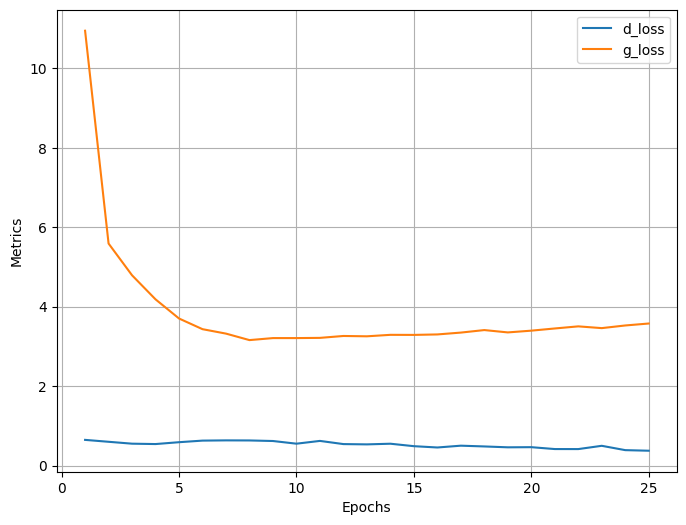

In [14]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

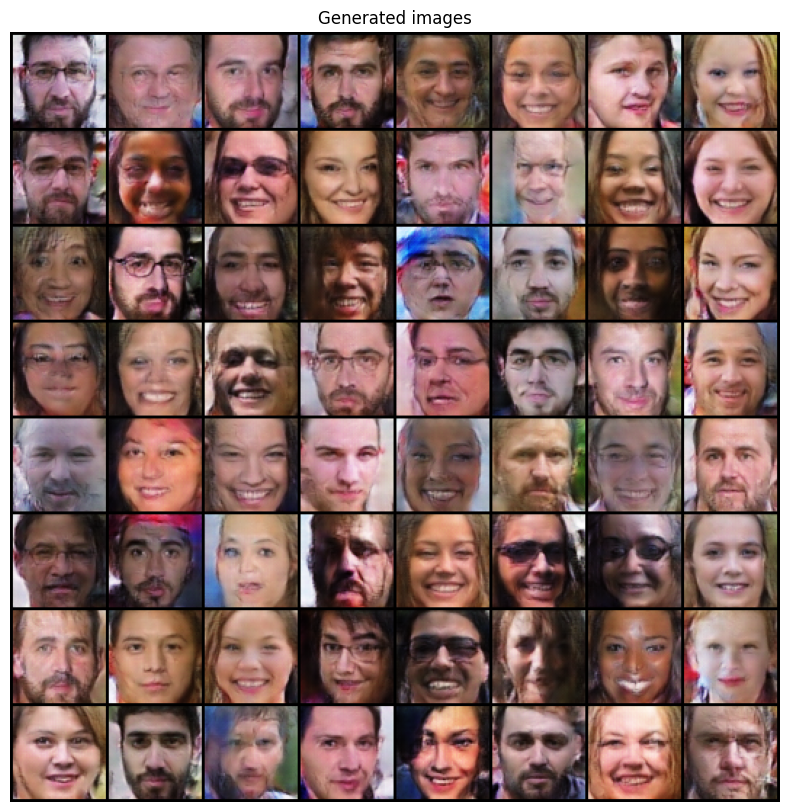

In [15]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')